In [1]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from dataset import WHDataset
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from transformer_sim import Config, TSTransformer
import metrics

In [2]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [3]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(420)
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Controls the input generation

In [4]:
# Overall settings
out_dir = "WH_checkpoints/numba410_400skip_decoder"
# out_dir = "WH_checkpoints/numba810_400skip_RNN_decoder_2"
# out_dir = "WH_checkpoints/numba16030_400skip_RNN_decoder"
# out_dir = "WH_checkpoints/numba40030_400skip_RNN_decoder"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 256
fixed_system = False # Are we testing on a fixed system?

# Compute settings
cuda_device = "cuda:3"
no_cuda = False
threads = 5
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  =  "cpu"
device = torch.device(device_name)
device_type = 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")

In [5]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir / "ckpt.pt", map_location=device)
cfg = exp_data["cfg"]
# For compatibility with initial experiment without seed
try:
    cfg.seed
except AttributeError:
    cfg.seed = None

In [6]:
loss = exp_data['LOSS']
loss_smooth = pd.Series(loss).rolling(100).mean()

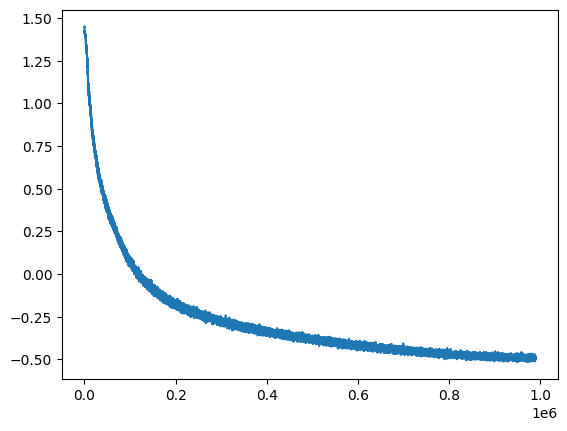

In [7]:
plt.figure()
plt.plot(loss_smooth, label="Smoothed loss")

In [8]:
model_args = exp_data["model_args"]
conf = Config(**model_args)
model = TSTransformer(conf).to(device)
del exp_data["model"]['before_enc_wte.bias']
del exp_data["model"]['before_enc_wte.weight']
model.load_state_dict(exp_data["model"]);

In [9]:
# Create data loader
lin_opts = dict(mag_range=cfg.mag_range, phase_range=cfg.phase_range, strictly_proper=True)
test_ds = WHDataset(nx=cfg.nx, nu=cfg.nu, ny=cfg.ny, 
                                        seq_len=cfg.seq_len_ctx+cfg.seq_len_skip+cfg.seq_len_n_in+cfg.seq_len_new,
                        system_seed=cfg.seed, input_seed=cfg.seed+1, noise_seed=cfg.seed+2,
                        **lin_opts)
#test_ds = LinearDynamicalDataset(nx=cfg.nx, nu=cfg.nu, ny=cfg.ny, seq_len=cfg.seq_len_ctx+cfg.seq_len_new)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=1)

In [10]:
batch_y, batch_u = next(iter(test_dl))
batch_y = batch_y.to(device)
batch_u = batch_u.to(device)
noise_std = 0.0
with torch.no_grad():
    batch_y_ctx = batch_y[:, :cfg.seq_len_ctx, :]
    batch_u_ctx = batch_u[:, :cfg.seq_len_ctx, :]
    batch_y_new = batch_y[:, cfg.seq_len_ctx+cfg.seq_len_skip:, :]
    batch_u_new = batch_u[:, cfg.seq_len_ctx+cfg.seq_len_skip:, :]
    batch_y_ctx = batch_y_ctx + torch.randn(batch_y_ctx.shape)*noise_std
    batch_y_mean = torch.zeros([batch_size,100,len(batch_y_ctx[0,0,:])])
    batch_y_std = torch.zeros([batch_size,100,len(batch_y_ctx[0,0,:])])
    for i in range(len(batch_y_ctx[0,0,:])):
        batch_y_mean[:,:,i:i+1], batch_y_std, _, _ = model(batch_y_ctx[:,:,i:i+1], batch_u_ctx, batch_u_new,batch_y_new[:,:,i:i+1],cfg.seq_len_n_in)

In [11]:
batch_y_mean = batch_y_mean.to("cpu").detach().numpy()
batch_y_std = batch_y_std.to("cpu").detach().numpy()
batch_y_new = batch_y_new.to("cpu").detach().numpy()
batch_u_new = batch_u_new.to("cpu").detach().numpy()

In [12]:
batch_sim_err = batch_y_new[:, cfg.seq_len_n_in:, :] - batch_y_mean[:, :, :]
batch_y_plus = batch_y_mean + batch_y_std * 3
batch_y_minus = batch_y_mean - batch_y_std * 3

In [13]:
t = np.arange(1, batch_u_new.shape[1]-cfg.seq_len_n_in+1)+cfg.seq_len_n_in# + cfg.seq_len_ctx+cfg.seq_len_skip

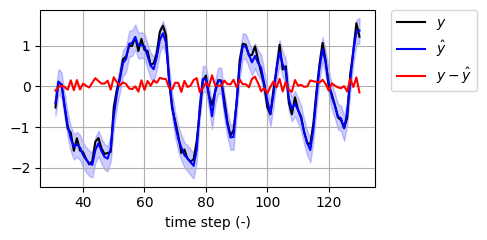

In [14]:
plt.figure(figsize=(5, 2.5))
idx = 12
plt.plot(t, batch_y_new[idx, cfg.seq_len_n_in:, :], 'k', label="$y$")
plt.plot(t, batch_y_mean[idx, :, :], 'b', label="$\hat y$")
plt.fill_between(x=t, y1=batch_y_minus[idx, :, 0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
plt.plot(t, batch_sim_err[idx, :, :], 'r', label="$y - \hat y$")
plt.grid(True)
plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
# plt.savefig(fig_path / "wh_sim_single_analysis_output.pdf")

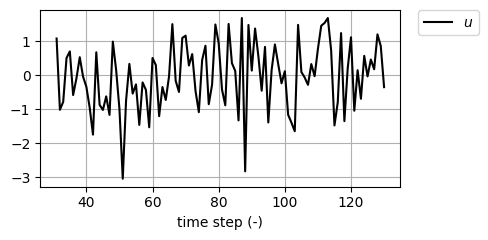

In [15]:
plt.figure(figsize=(5, 2.5))
idx = 20
plt.plot(t, batch_u_new[idx, cfg.seq_len_n_in:, :], 'k', label="$u$")
plt.grid(True)
plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
# plt.savefig(fig_path / "wh_sim_single_analysis_input.pdf")

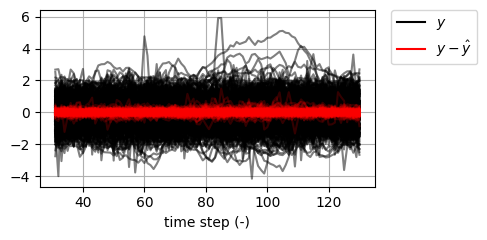

In [16]:
plt.figure(figsize=(5, 2.5))
#plt.ylim([-3, 3])
plt.plot(t, batch_y_new[:, cfg.seq_len_n_in:, :].squeeze(-1).T, "k", alpha=0.5);
plt.plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
plt.plot(t, batch_sim_err.squeeze(-1).T, "r", alpha=0.2);
plt.plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y - \hat y$");
plt.grid(True)
plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
# plt.savefig(fig_path / "wh_sim_batch_8000ctx_64patched.pdf")

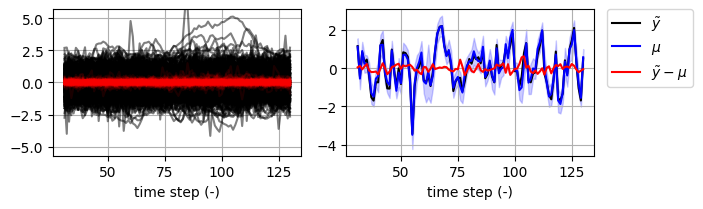

In [17]:
#matplotlib.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'size': 14})
#matplotlib.rc('text', usetex=True)
#matplotlib.rc('axes', grid=True)
idx = 20
fix, ax = plt.subplots(1,2, sharex=True, sharey=False, figsize=(7, 2.2))
ax[0].plot(t, batch_y_new[:, cfg.seq_len_n_in:, :].squeeze(-1).T, "k", alpha=0.5);
ax[0].plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
ax[0].plot(t, batch_sim_err.squeeze(-1).T, "r", alpha=0.1);
ax[0].plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y-\hat y$")
ax[0].set_ylim((-5.7, 5.7))
ax[0].set_xlabel("time step (-)")
ax[0].grid(True)

ax[1].plot(t, batch_y_new[idx, cfg.seq_len_n_in:, :], 'k', label=r"$\tilde y$")
ax[1].plot(t, batch_y_mean[idx, :, :], 'b', label="$\mu$")
ax[1].fill_between(x=t, y1=batch_y_minus[idx, :, 0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
ax[1].plot(t, batch_sim_err[idx, :, :], 'r', label=r"$\tilde y - \mu$")
ax[1].set_xlabel("time step (-)")
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
# plt.savefig(fig_path / "wh_sim_batch_single_16000ctx.pdf")
# plt.savefig(fig_path / "wh_sim_batch_single.png")

In [14]:
skip = 0
rmse = metrics.rmse(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(rmse.mean())

0.16559598


<StemContainer object of 3 artists>

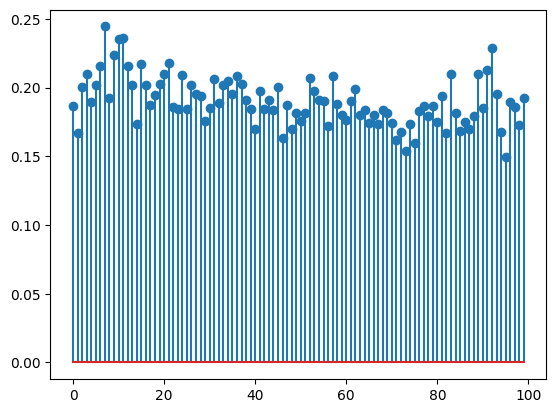

In [15]:
skip = 0
rmse = metrics.rmse(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=0)
plt.stem(rmse)

In [20]:
print(f'iterations: {exp_data["cfg"].max_iters}')
print(f'train_time: {exp_data["train_time"]/3600/24} days')
print(f'WH_binary_on_CSTR_binaryinput: {rmse.mean()}')

iterations: 1000000
train_time: 4.416342371506271 days
WH_binary_on_CSTR_binaryinput: 0.13292020559310913


* 400 ctx no patch: 0.16559597849845886 rmse, 1.028960087241398 days
* 800 ctx RNN patch: 0.14270329475402832 rmse, 1.0381489119154435 days
* 16000 ctx RNN patch: 0.12866806983947754 rmse, 1.6794429362289331 days
* 40000 ctx RNN patch: 0.1293572187423706 rmse, 4.416342371506271 days
